In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [19]:
%matplotlib inline
%load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
import os
import inspect

SCRIPT_DIR = os.path.realpath(os.path.dirname(inspect.getfile(inspect.currentframe())))
CMAP2D_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, 'src/cmap2d'))
if sys.path.count(CMAP2D_PATH) == 0:
    sys.path.append(CMAP2D_PATH)

PARENT_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, '..'))
if sys.path.count(PARENT_PATH) == 0:
    sys.path.append(PARENT_PATH)
    
import cmap2d

In [258]:
import csv
import shapefile
import shapely.geometry as geom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl

import math
import numpy as np
from numpy import linalg as la
import statistics as stat
import itertools

import ternary
from ternary.helpers import simplex_iterator

In [293]:
def plot_pa_data(colors, cmap=None, norm=None, hatch=None):
    if cmap is not None:
        fig = plt.figure()#figsize=(8, 3))
        ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    for county,v in COUNTY_SHAPES.items():
        color = colors[county]
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
        kwargs = {"facecolor":color}
        if hatch is not None and county in hatch:
            kwargs["hatch"] = hatch[county]
        ax.add_feature(cf, **kwargs)

    ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
    ax.set_aspect(1)
    if cmap is not None:
        cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='max')
    plt.show()

In [121]:
STATE = "PA"

sf = shapefile.Reader("PA/tl_2011_us_county/tl_2011_us_county")
COUNTY_SHAPES = {}
iter = sf.iterShapeRecords()
for i in iter:
    if i.record[0] == '42':
        s = geom.shape(i.shape)
        COUNTY_SHAPES[i.record[4].capitalize()]=s
#         print(i.record[4].capitalize(),s.area)
        
print(len(COUNTY_SHAPES.keys()))

67


In [153]:
DEM = "DEM"
REP = "REP"

CANDIDATES = {
    2000: {DEM: 'Al Gore', REP: 'George Bush'},
    2004: {DEM: 'John Kerry', REP: 'George Bush'},
    2008: {DEM: 'Barack Obama', REP: 'John Mccain'},
    2012: {DEM: 'Barack Obama', REP: 'Mitt Romney'},
    2016: {DEM: 'Clinton, Hillary', REP: 'Trump, Donald J'}
}

STATE_CODES = {
    "PA": 42
}

YEAR = 2008

def load_results(year):
    res = {}
    with open("PA/"+str(year) + "_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["County"]
            del row["County"]

            res[county] = row
    return res

def load_registrations(year):
    res = {}
    with open("PA/" + str(year) + "_registerd_voters_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            res[row["County"].capitalize()] = row
    return res

def load_data(year):
    return (load_registrations(year), load_results(year), 
            CANDIDATES[year][REP], CANDIDATES[year][DEM])


VOTERS, COUNTY_RESULTS, RC, DC = load_data(YEAR)
print(COUNTY_RESULTS['Allegheny'])
print(VOTERS['Allegheny'])

dem_votes = sum([k[DC] for k in COUNTY_RESULTS.values()])
rep_votes = sum([k[RC] for k in COUNTY_RESULTS.values()])
total = sum([sum(k.values()) for k in COUNTY_RESULTS.values()])
vap = sum([VOTERS[k]["ALL"] for k in VOTERS.keys()])
winner = DC
if rep_votes > dem_votes:
    winner = RC
print(winner+" won the election by " + str(round(abs(dem_votes-rep_votes)/total*100, 2)) + "%")
print("there was a total of " + str(int(total)) + " votes cast")
print("voter turnout for state was " + str(round(total/vap*100,2)) + "% (" + str(int(total)) + " of " +str(int(vap)) + ")")

{'John Mccain': 271886.0, 'Bob Barr': 2008.0, 'Write-in': 0.0, 'Ralph Nader': 3919.0, 'Barack Obama': 372474.0}
{'ALL': 956096.0, 'County': 'ALLEGHENY', 'OTH': 104554.0, 'REP': 256320.0, 'DEM': 595222.0}
Barack Obama won the election by 10.33%
there was a total of 6006568 votes cast
voter turnout for state was 68.6% (6006568 of 8755588)


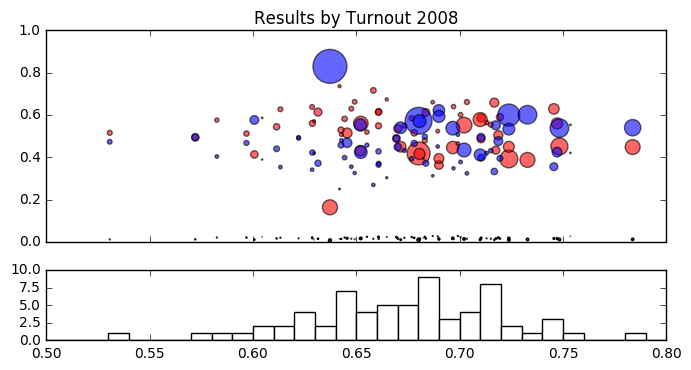

In [136]:
# correlation between voter turnout and results

turnout, dem, rep, oth, size = [],[],[],[],[]
for county in VOTERS.keys():
    vap = VOTERS[county]["ALL"]
    all_votes = sum(COUNTY_RESULTS[county].values())
    dems = COUNTY_RESULTS[county][DC]
    reps = COUNTY_RESULTS[county][RC]
    others = all_votes - dems - reps
    size.append(all_votes)
    dem.append(dems/all_votes)
    rep.append(reps/all_votes)
    oth.append(others/all_votes)
    turnout.append(all_votes/vap)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 4),
                              gridspec_kw = {'height_ratios':[3, 1]})
sizer = lambda votes: [v*s/1000 for v,s in zip(votes,size)]
ax1.scatter(turnout, rep, c='r', alpha=0.6, s=sizer(rep))
ax1.scatter(turnout, dem, c='b', alpha=0.6, s=sizer(dem))
ax1.scatter(turnout, oth, c='g', alpha=1, s=sizer(oth))
ax1.set_ylim([0,1.0])
ax1.set_xlim([0.5, 0.8])
ax1.set_title("Results by Turnout " + str(YEAR))

# distribution of voter turnout
n, bins, patches = ax2.hist(turnout, bins=np.linspace(0,1.0, 101), facecolor='white', alpha=1)
start, end = ax2.get_ylim()
ax2.yaxis.set_ticks(np.linspace(0, math.ceil(end/5)*5, 5))
ax2.set_ylim([0, math.ceil(end/5)*5])


plt.show()

In [ ]:
x0v,x0r = load_data(2008)
x1v,x1r = load_data(2012)
yv,yr = load_data(2016)

counties = x0v.keys()

-0.061969184585054404 0.14073478719757637
-0.15846317135789945 0.03241301316098699


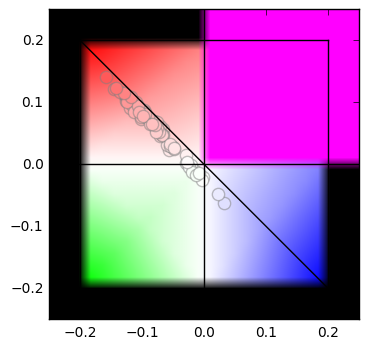

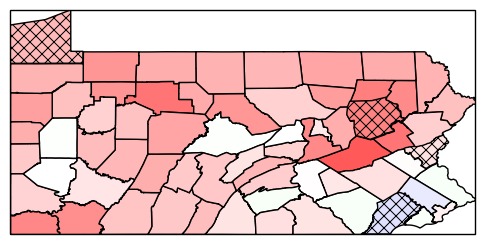

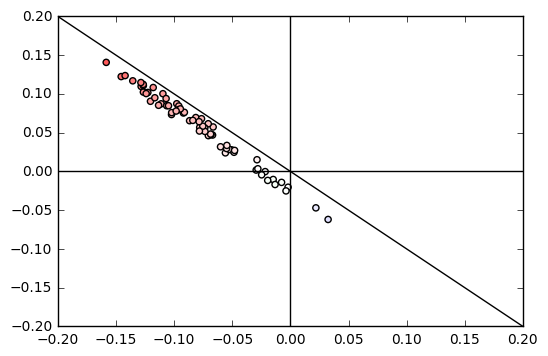

In [303]:
xvot,xres,xrc,xdc = load_data(2012)
yvot,yres,yrc,ydc = load_data(2016)
counties = xvot.keys()

def get_votes(results, rc, dc):
    all_votes = sum(results.values())
    dems = results[dc]/all_votes
    reps = results[rc]/all_votes
    return reps, dems, all_votes

r_delta, d_delta, flipped = {},{},{}
for county in counties:
    old_rep, old_dem, old_all = get_votes(xres[county], xrc, xdc)
    new_rep, new_dem, new_all = get_votes(yres[county], yrc, ydc)
    r_delta[county] = new_rep - old_rep
    d_delta[county] = new_dem - old_dem
    flip = (new_dem>new_rep and old_rep>old_dem) or (new_rep>new_dem and old_dem>old_rep)
    if flip:
        flipped[county] = 'xx'


print(min(r_delta.values()), max(r_delta.values()))
print(min(d_delta.values()), max(d_delta.values()))

def make_cmap(xmin, xmax, ymin, ymax, ll, lr, ur, ul):
    return cmap2d.ColorMapCrude([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]],
                           [ll, lr, ur, ul])
        
cmap = make_cmap(-.2, .2, -.2, .2, (0,1,0), (0,0,1), (1,1,1), (1,0,0))
# r_cmap = make_cmap(-.2, 0, 0, .2, (1,1,0), (1,1,1), (1,0.5,0.5), (1,0,0))
# d_cmap = make_cmap(0, .2, -.2, 0, (0,1,1), (0,0,1), (0.5,0.5,1), (1,1,1))
# o_cmap = make_cmap(-.2, 0, -.2, 0, (0,1,0), (0,1,1), (1,1,1), (1,1,0))

r_cmap = make_cmap(-.2, 0, 0, .2, (1,1,1), (1,1,1), (1,0.5,0.5), (1,0,0))
d_cmap = make_cmap(0, .2, -.2, 0, (1,1,1), (0,0,1), (0.5,0.5,1), (1,1,1))
o_cmap = make_cmap(-.2, 0, -.2, 0, (0,1,0), (1,1,1), (1,1,1), (1,1,1))


def color_code(point):
    x,y = point
    if x>0:
        if y>0:
            return (1,0,1)
        else:
            return d_cmap(point)
    else:
        if y>0:
            return r_cmap(point)
        else:
            return o_cmap(point)

color_code._coords = cmap._coords

x = [d_delta[county] for county in counties]
y = [r_delta[county] for county in counties]

colors = {county:cmap((d_delta[county], r_delta[county])) for county in counties}
colors = {county:color_code((d_delta[county], r_delta[county])) for county in counties}

plt.plot([-.25,.25], [0,0], 'k')
plt.plot([0,0], [-.25,.25], 'k')
plt.plot([-.4,.4], [.4,-.4], 'k')
cmap2d.plot_cmap(color_code, scale=4, buffer=0.05, show=False)
cmap2d.plot_color_points([v for v in zip(x,y)], [colors[c] for c in counties])
plt.show()

# cmap2d.plot_cmap(color_code, scale=4)

plot_pa_data(colors, hatch=flipped)

plt.scatter(x,y, c=[colors[c] for c in counties])
plt.plot([-.25,.25], [0,0], 'k')
plt.plot([0,0], [-.25,.25], 'k')
plt.plot([-.2,.2], [.2,-.2], 'k')
plt.xlim([-.2,.2])
plt.ylim([-.2,.2])
plt.show()



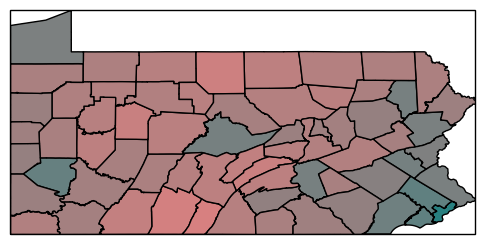

In [23]:
values = {}
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    values[county] = (meta[RC]/total,0.5,0.5)
plot_pa_data(values)

28281236.1447 27698.6789508


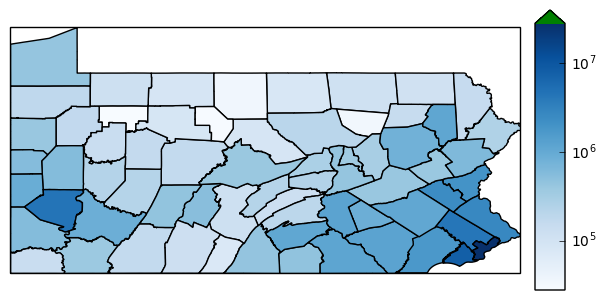

In [42]:

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.LogNorm()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    vap = int(dict(VOTERS[county])["ALL"])
    value = vap/v.area
    to_plot.append((county, v, value))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", k, value, color)

plot_pa_data(values, cmap=colormap, norm=norm)

Fayette 1.0167548500881833
Cambria 1.069633229554256
Greene 1.0702224052718288


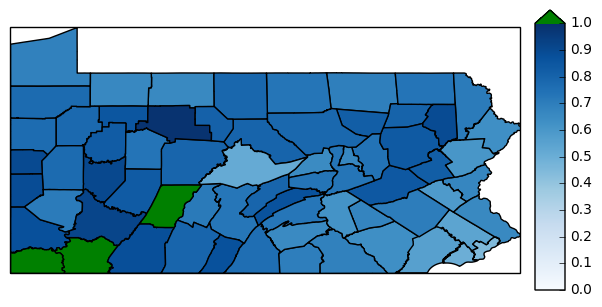

In [43]:
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

values = {}
for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[k]["ALL"]
#     color = total/vap
#     value = int(meta["CLINTON, HILLARY"])/int(VOTERS[k]["DEM"])
#     value = int(meta["TRUMP, DONALD J"])/int(VOTERS[k]["REP"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])
    value = trump/((vap-VOTERS[k][DEM])-(total-trump-clinton))
#     value = clinton/((vap-VOTERS[k]["REP"])-(total-trump-clinton))
    color = colormap(value)
    values[k] = color
    if value > 1:
        print(k, value)

plot_pa_data(values, cmap=colormap)

0.781357745809 0.611632768174
['Adams: 0.7119042978997706', 'Allegheny: 0.6956432861439822', 'Armstrong: 0.7430438052265463', 'Beaver: 0.6959293469168523', 'Bedford: 0.6859257109692397', 'Berks: 0.6772109995688859', 'Blair: 0.6684868497128393', 'Bradford: 0.6827972696608324', 'Bucks: 0.7476509484153266', 'Butler: 0.7480169283781596', 'Cambria: 0.726719668164535', 'Cameron: 0.6761521806371791', 'Carbon: 0.6802539020866394', 'Centre: 0.6173778386748932', 'Chester: 0.7525804621546329', 'Clarion: 0.7275631716526285', 'Clearfield: 0.6438770525682936', 'Clinton: 0.6903139013452915', 'Columbia: 0.6643401170621801', 'Crawford: 0.7023735926113266', 'Cumberland: 0.7282019040776001', 'Dauphin: 0.6876888396117852', 'Delaware: 0.6909087826299688', 'Elk: 0.712641406906091', 'Erie: 0.6502781370600544', 'Fayette: 0.6411977961695328', 'Forest: 0.7199039327529271', 'Franklin: 0.7495700219288817', 'Fulton: 0.7339719168390116', 'Greene: 0.6620185922974767', 'Huntingdon: 0.6616970551694034', 'Indiana: 0.72

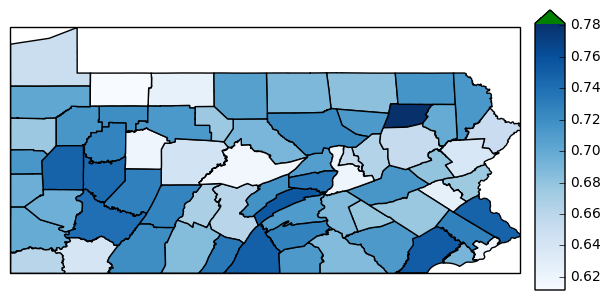

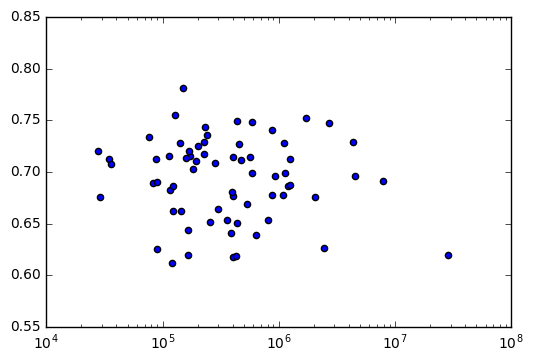

In [44]:
# colormap = cm.get_cmap("bwr_r")
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.Normalize()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[county]["ALL"]
    
    republicans = VOTERS[county]["REP"]/vap*100
    democrats = VOTERS[county]["DEM"]/vap*100
    value = ((clinton-trump)/total*100)-(democrats-republicans)
    value =total/vap
    d = vap/v.area
    to_plot.append((county, v, value, d))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)
m = max(abs(norm.vmax), abs(norm.vmin))
# norm = colors.Normalize(vmin=-m, vmax=m)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value, g) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", county, value, color)

print([x[0] + ": " + str(x[2]) for x in sorted(to_plot, key=lambda x: x[0])])
    
plot_pa_data(values, cmap=colormap, norm=norm)

plt.figure()
plt.scatter([x[3] for x in to_plot], [x[2] for x in to_plot])
ax = plt.gca()
ax.set_xscale('log')
plt.show()

[-38.34465780930415, 11.623915697094676, -34.4458130945675, -15.928849899950748, -0.45707988527535726, -16.503523713288835, -29.386523739017612, -36.16644336895717, -14.119031035119361, 0.9356092683468944, -14.198407022655978, -55.616510549202616, -20.23859938797255, -20.328587201796054, -29.653798492336715, -28.41800085729795, -19.600853404989355, -3.947183982604585, -28.793889831136823, -13.913787700581715, 17.728621176865914, -25.821993200306, -12.498192988996458, -21.8906931838133, -16.556037697906625, 0.041017506783038726, -15.859449866688422, -14.595523691939029, 14.461174468789737, -31.760982395881598, -36.29158399966531, -36.286241897730044, -17.407216559992822, -36.058065337058466, -14.772136673844969, -24.232672519846517, -51.582096881624196, -1.2345200700326968, -13.0328907316615, -14.792319867917158, -24.45862613707406, -31.702141681479475, -0.3311431392942339, -22.74822568633429, -27.28960402086992, -61.244734646613594, -21.979040723239798, -9.985612893895485, -35.77597748

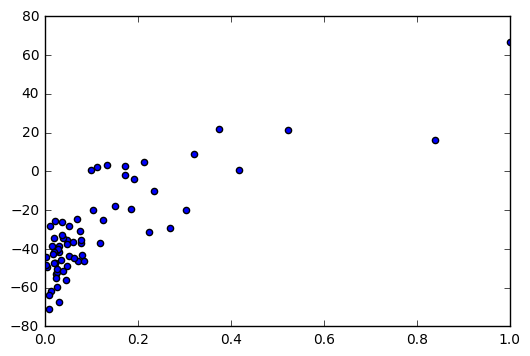

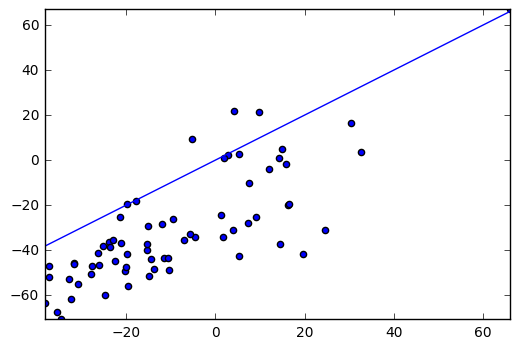

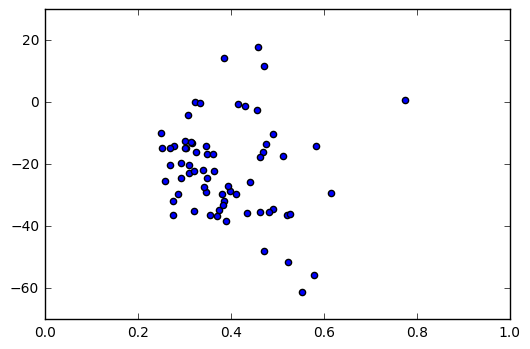

In [45]:
x=[]
clintons = []
trumps=[]
counties = COUNTY_RESULTS.keys()
vap=[int(dict(VOTERS[c])["ALL"]) for c in counties]
vap = [i/max(vap) for i in vap]

for county in COUNTY_RESULTS.keys():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    x.append((clinton-trump)/total*100)
    trumps.append(trump/total*100)
    clintons.append(clinton/total*100)
#     x.append((total-clinton-trump)/total*100)
plt.figure()
plt.scatter(vap,x)
plt.xlim([0,1])

republicans = [int(dict(VOTERS[c])["REP"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
democrats = [int(dict(VOTERS[c])["DEM"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
x_v = [(i-j)*100 for i,j in zip(democrats,republicans)]
plt.figure()
plt.scatter(x_v, x)
print([i-j for i,j in zip(x, x_v)])
plt.plot([-100,100],[-100,100])
plt.xlim([min(x_v),max(x_v)])
plt.ylim([min(x),max(x)])
# plt.xlim([0,1])
plt.figure()
plt.scatter(democrats,[i-j for i,j in zip(x,x_v)])
plt.xlim([0,1])
# plt.figure()
# plt.scatter(vap,democrats)
# plt.xlim([0,1])
plt.show()


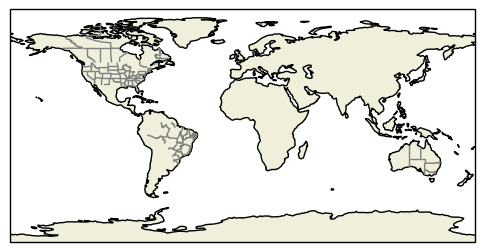

In [46]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([80, 170, -45, 30])

# Put a background image on for nice sea rendering.
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                    ''.format(SOURCE, LICENSE),
                    loc=4, prop={'size': 12}, frameon=True)
# ax.add_artist(text)

plt.show()

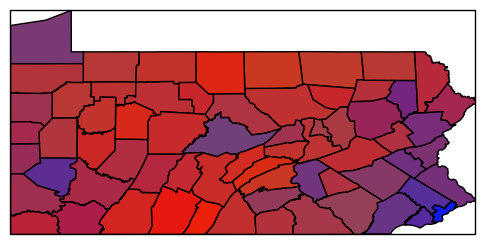

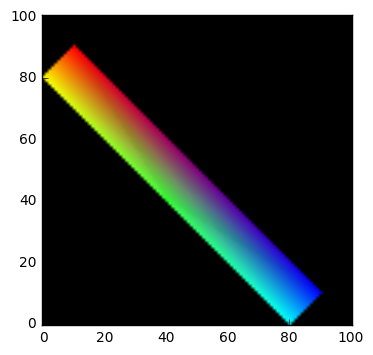

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())


# fig = plt.figure()#figsize=(8, 3))
# ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
# ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
cmap = cmap2d.ColorMapCrude([[80,0], [90,10], [10,90], [0,80], [40,40]], 
                            [(0,1,1), (0,0,1), (1,0,0), (1,1,0), (0,1,0)])

# values = []
# for county,v in COUNTY_RESULTS.items():
#     meta = dict(COUNTY_RESULTS[k])
#     del meta["County"]
#     total = sum([int(f) for f in meta.values()])
#     vap = int(dict(VOTERS[k])["ALL"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])

for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    point = [clinton/total*100, trump/total*100]
    (x,y) = point
    if 95>x+y:
        print (k, int(x+y))
    color = cmap(point)
    cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
    ax.add_feature(cf, facecolor=color)

ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
ax.set_aspect(1)

# cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=colors.Normalize(vmin=0, vmax=1), extend='max')

plt.show()

cmap2d.plot_cmap(cmap, scale=1, bounds=cmap._coords, constrain=True)

plotting SimplexColorMap shape 0
plotting TernaryColorMap shape 0
plotting ProjectionColorMap shape 0
plotting AvgColorMap shape 0


/home/ocderby/Documents/code/elections_2016/src/cmap2d/cmap2d/cmap2d.py:90: RuntimeWarning: divide by zero encountered in true_divide
  distances = self._max_dist/distances


plotting ColorMapCrude shape 0
plotting ColorMap shape 0
plotting ColorMap2 shape 0


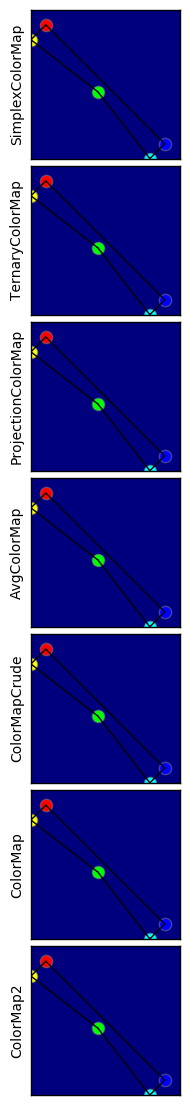

In [16]:
case = [[cmap._coords, cmap._colors]]
classes = [cmap2d.SimplexColorMap, cmap2d.TernaryColorMap, cmap2d.ProjectionColorMap, cmap2d.AvgColorMap,
           cmap2d.ColorMapCrude, cmap2d.ColorMap, cmap2d.ColorMap2]
cmap2d.run_tests(classes,case, scale=1, constrain=False)

In [57]:
PAPER = 0
MIXED = 1
DRE = 2

VOTE_METHOD = {
"Adams": PAPER,
"Allegheny": DRE,
"Armstrong": DRE,
"Beaver": DRE,
"Bedford": MIXED,
"Berks": DRE,
"Blair": DRE,
"Bradford": DRE,
"Bucks": DRE,
"Butler": DRE,
"Cambria": DRE,
"Cameron": DRE,
"Carbon": DRE,
"Centre": PAPER,
"Chester": MIXED,
"Clarion": DRE,
"Clearfield": DRE,
"Clinton": DRE,
"Columbia": MIXED,
"Crawford": DRE,
"Cumberland": MIXED,
"Dauphin": DRE,
"Delaware": DRE,
"Elk": DRE,
"Erie": DRE,
"Fayette": MIXED,
"Forest": DRE,
"Franklin": PAPER,
"Fulton": PAPER,
"Greene": DRE,
"Huntingdon": PAPER,
"Indiana": PAPER,
"Jefferson": DRE,
"Juniata": PAPER,
"Lackawanna": PAPER,
"Lancaster": MIXED,
"Lawrence": DRE,
"Lebanon": DRE,
"Lehigh": DRE,
"Luzerne": MIXED,
"Lycoming": DRE,
"Mckean": DRE,
"Mercer": DRE,
"Mifflin": PAPER,
"Monroe": DRE,
"Montgomery": DRE,
"Montour": PAPER,
"Northampton": DRE,
"Northumberland": DRE,
"Perry": DRE,
"Philadelphia": DRE,
"Pike": DRE,
"Potter": DRE,
"Schuylkill": DRE,
"Snyder": PAPER,
"Somerset": DRE,
"Sullivan": DRE,
"Susquehanna": PAPER,
"Tioga": DRE,
"Union": DRE,
"Venango": DRE,
"Warren": DRE,
"Washington": DRE,
"Wayne": PAPER,
"Westmoreland": MIXED,
"Wyoming": DRE,
"York": DRE
}

In [58]:
counties = VOTE_METHOD.keys()
x = [VOTE_METHOD[c] for c in counties]
totals = []
clinton = []
trump = []
delta = []
for c in counties:
    meta = dict(COUNTY_RESULTS[c])
    del meta["County"]
    total = sum([int(f) for f in meta.values()])
    totals.append(total)
    clinton.append(int(meta[DC])/total)
    trump.append(int(meta[RC])/total)
    delta.append((clinton[-1]-trump[-1])*100)
plt.figure()
plt.scatter(x,y)
plt.figure()
plt.scatter(x,clinton, color='blue')
plt.scatter(x,trump, color='red', marker='x')
plt.figure()
plt.scatter(x,delta)
d = np.array(delta)
k = np.array(x)

means_x = list(set(x))
means = [stat.mean(d[k==i]) for i in means_x]
medians = [stat.median(d[k==i]) for i in means_x]
plt.scatter(means_x, means, marker='+', color='red')
plt.scatter(means_x, medians, marker='x', color='green')
print(means[2]-means[1])
plt.show()

KeyError: 'County'

In [ ]:
scale=100

data = dict()
for (i, j, k) in simplex_iterator(scale):
    data[(i, j, k)] = cmap((i,j))

figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", colormap=False) # Allow colors as rgba tuples
tax.boundary()

tax.ticks(axis='lbr', multiple=10, linewidth=1)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()

plt.show()